### Homework 5: Practice Machine Learning
**<p>BMED 8813<br/>
Problem 1<br/>
Maria Ahmad - mahmad42@gatech.edu<p/>**

<p>Classification. You have two groups of subjects, known from existing “gold standard” tests to belong to groups D (disease) or N (non-disease). For each subject in each group, two candidate biomarkers identified in your early investigations have been measured.The test data is available in hw5-data.mat. In writing your code, you can assume that this data file will be available in the working directory or MATLAB path.<p/>

In [524]:
# /home/deeto/anaconda3/bin/python3

import numpy
import scipy
import scipy.io
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import math
import random
# from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Part a) Display the covariance matrices of each group, D and N.

In [525]:
def part_a_read_the_data():
    print('Part a:')
    print('Displaying covariance matrices')
    # read in the data
    data = {}
    contents = scipy.io.loadmat('hw5-data.mat')
    # the data is in a dictionary, so parse through the dictionary
    for key in contents: 
        if key == 'D': # for disease
            print('Diseased group:')
            # 38 rows/samples, 2 columns/biopsies
            # cov is 38 x 38, but should be 2x2
            D_contents = contents[key]
            covMatD = numpy.cov(D_contents)
            D_contents_transpose = numpy.transpose(D_contents)
            data['D_original'] = D_contents
            covMatDtranspose = numpy.cov(D_contents_transpose) # 2x2
            data['covarianceMatrixD'] = covMatD
            data['D_transpose'] = D_contents_transpose
            data['covDtranspose'] = covMatDtranspose
            print(covMatDtranspose)
        elif key == 'N': # normal, undiseased
            print('Normal group:')
            # 44 rows, 2 columns
            # cov is 44 x 44
            N_contents = contents[key]
            N_contents_transpose = numpy.transpose(N_contents)
            covMatN = numpy.cov(N_contents)
            covMatNtranspose = numpy.cov(N_contents_transpose)
            data['N_original'] = N_contents
            data['covarianceMatrixN'] = covMatN
            data['N_transpose'] = N_contents_transpose
            data['covNtranspose'] = covMatNtranspose
            print(covMatNtranspose)
    print('--------------------\n\n')
    return data

Part b) Assuming that these groups follow multivariate normal distributions, use the covariance matrices to generate a 3D surface plot that clearly shows the PDFs of both groups. To receive full credit, both: **(1) the full extent of the distribution of both groups**,  and **(2) the location of the decision boundary (a “valley” between the “hills” of the two PDFs)**, should be clearly visible.

Notes:<br/>
A multivariate PDF is 2D \[\#   \#\].<br/>
So the shape is (number number).
A 38 by 38 array is still 2D.
Covariance matrix should be 2x2. So it is very specific the shape. 


In [526]:
def part_b_3D_surface_plot(data):
    print('Part b')
    
    D_original = data['D_original']
    D_transpose = data['D_transpose']
    N_original = data['N_original']
    N_transpose = data['N_transpose']
    covMatD = data['covarianceMatrixD']
    covMatN = data['covarianceMatrixN']
    covMatD_transpose = data['covDtranspose']
    covMatN_transpose = data['covNtranspose']

    # Diseased class
    x = D_original[:,0] # (38,)
    y = D_original[:,1] # (38,)
    X,Y = numpy.meshgrid(x,y)
    pos = numpy.dstack((X,Y))
    mu = numpy.mean(D_original,axis=0) # (2,)
    the_cov = covMatD_transpose # (2,2)
    rv = multivariate_normal(mu,the_cov)
    Z = rv.pdf(pos)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection = '3d')
    ax.plot_surface(X,Y,Z)
    fig.show()
    plt.title('Part b: Diseased class')
    plt.show()
    plt.savefig('problem1_b1.png')
    print('Plot of diseased class saved')
    plt.close()
    
    # Normal class
    x = N_original[:,0] # (38,)
    y = N_original[:,1] # (38,)
    X,Y = numpy.meshgrid(x,y)
    pos = numpy.dstack((X,Y))
    mu = numpy.mean(N_original,axis=0) # (2,)
    the_cov = covMatN_transpose # (2,2)
    rv = multivariate_normal(mu,the_cov)
    Z = rv.pdf(pos)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection = '3d')
    ax.plot_surface(X,Y,Z)
    fig.show()
    plt.title('Part b: Normal class')
    plt.show()
    plt.savefig('problem1_b2.png')
    print('Plot of normal class saved')
    plt.close()
    print('--------------------\n\n')
    return

<p>Part c) Calculate the Bayesian decision function for deciding between groups D and N. Do this “manually” –i.e. by using the decision function formulae from HW4 and the lectures (DO NOT use fitcnb, sklearn.naive_bayes, or similar built-in functions). Assume that the disease state impacts about 0.5% of the general population, keeping in mind that the sample sizes of D and N are not equal. Display the accuracy of your classifier. Plot your results:<p/>
1. Draw the decision boundary (i.e. the contours where the decision function equals zero) as a black line.<br/> **Hint: see MATLAB’s contour, and Python’s matplotlib.pyplot.contour**
2. Plot the original D and N data points. Color by group: red for D, and blue for N. Use your point markers to indicate accuracy: “O” when correctly classified by your Bayes classifier, “X” if incorrectly classified.


In [527]:
def part_c_Bayesian_decision_function(data):
    print('Part c:')
    # Initial terms from data
    D_original = data['D_original'] # (38,2)
    D_transpose = data['D_transpose'] # (2,38)
    N_original = data['N_original'] # (44,2)
    N_transpose = data['N_transpose'] # (2,44)
    covMatD = data['covarianceMatrixD'] # (38,38)
    covMatN = data['covarianceMatrixN'] # (44,44) 
    covMatD_transpose = data['covDtranspose'] # (2,2) # cov from the transposed data
    covMatN_transpose = data['covNtranspose'] # (2,2) # cov from the transposed data
    
    # Initial conditions
    prob_disease = 0.005 # probability of having the disease
    prob_normal = 0.995 # probability of being normal
    pop_disease = int(numpy.size(D_original) * (1/2)) # disease population size
    pop_normal = int(numpy.size(N_original) * (1/2)) # normal population size
    cov_disease = covMatD_transpose # covariance matrix for disease group
    cov_normal = covMatN_transpose # covariance matrix for normal group
    twoPi = 2 * math.pi
    cov_disease_det = numpy.linalg.det(cov_disease) # |C|
    cov_normal_det = numpy.linalg.det(cov_normal) # |C|
    ln_cov_disease_det = numpy.log(cov_disease_det) # ln(|C|)
    ln_cov_normal_det = numpy.log(cov_normal_det) 
    inverse_cov_disease = numpy.linalg.inv(cov_disease) # C^-1
    inverse_cov_normal = numpy.linalg.inv(cov_normal)
    
    # mean disease vector
    mean_disease_centroid = numpy.mean(D_original,axis=0) # (1x2)
    # mean normal vector
    mean_normal_centroid = numpy.mean(N_original,axis=0) # (1x2)
    ## Note: though normally this vector should be 2x1, and once transposed it should be 1x2, 
    ## In this case, its already in the 1x2 form
    
    # math formulas
    # ln(P_normal) - ln(P_disease)
    part1 = math.log(prob_normal) - math.log(prob_disease)
    # -.5 * N_normal * ln(2pi) + .5 * N_disease * ln(2pi)
    part2 = (-1/2) * pop_normal * math.log(twoPi) + (1/2) * pop_disease * math.log(twoPi)
    # -.5 * ln(|C_normal|) + .5 * ln(|C_disease|)
    part3 = (-1/2) * ln_cov_normal_det + (1/2) * ln_cov_disease_det    
    answers = {}
    
    # accuracy count initializer
    accurate = 0 
    
    # last math part
    count = 1
    
    # arrays which will contain decision functions
    N_answers = numpy.array([])
    answers['N answer'] = N_answers
    D_answers = numpy.array([])
    answers['D answer'] = D_answers
    
    for normal_sample in N_original:
        N_answers = answers['N answer']
        
        # x - mu
        x_minus_mu_N = normal_sample - mean_normal_centroid
        x_minus_mu_N = numpy.reshape(x_minus_mu_N,(2,1)) # editing the shape
        # xT - muT
        x_minus_mu_transposed_N = numpy.transpose(x_minus_mu_N) # transposition
        
        # matrix mulitplication using dot
        firstDot = numpy.dot(-.5,x_minus_mu_transposed_N)
        secondDot = numpy.dot(firstDot,inverse_cov_normal)
        thirdDot = numpy.dot(secondDot,x_minus_mu_N)
        
        part4a = thirdDot
        
        # x - mu
        x_minus_mu_D = normal_sample - mean_disease_centroid
        x_minus_mu_D = numpy.reshape(x_minus_mu_D,(2,1))
        # xT - muT
        x_minus_mu_transposed_D = numpy.transpose(x_minus_mu_D)
        
        firstDot = numpy.dot(.5,x_minus_mu_transposed_D)
        secondDot = numpy.dot(firstDot,inverse_cov_disease)
        thirdDot = numpy.dot(secondDot,x_minus_mu_D)
        
        part4b = thirdDot
        
        # adding all the values together
        decision_function = part1 + part2 + part3 + float(part4a) + float(part4b)
        
        # assessing classification and accuracy
        if decision_function > 0:
            classification = 'N'
            answers['N'+str(count)] = [normal_sample,'N',classification]
        elif decision_function < 0:
            classification = 'D'
            answers['N'+str(count)] = [normal_sample,'N',classification]
        elif decision_function == 0:
            classification = random.randint(0,1)
            answers['N'+str(count)] = [normal_sample,'N',classification]
            
        # accuracy
        if classification == 'N':
            accurate += 1
        count += 1
        N_answers = numpy.append(N_answers,decision_function)
        answers['N answer'] = N_answers
    
    print('Normal class:')
    print('# accurate: '+str(accurate))
    print('Accuracy: '+str(accurate/44*100)+'%')
    
    accurate2 = 0
    count = 1
    for disease_sample in D_original:
        D_answers = answers['D answer']
        # x - mu
        x_minus_mu_N = disease_sample - mean_normal_centroid
        x_minus_mu_N = numpy.reshape(x_minus_mu_N,(2,1))
        # xT - muT
        x_minus_mu_transposed_N = numpy.transpose(x_minus_mu_N)

        # matrix multiplication dot
        firstDot = numpy.dot(-.5,x_minus_mu_transposed_N)
        secondDot = numpy.dot(firstDot,inverse_cov_normal)
        thirdDot = numpy.dot(secondDot,x_minus_mu_N)
        
        part4a = thirdDot
        
        # x - mu
        x_minus_mu_D = disease_sample - mean_disease_centroid
        x_minus_mu_D = numpy.reshape(x_minus_mu_D,(2,1))
        # xT - muT
        x_minus_mu_transposed_D = numpy.transpose(x_minus_mu_D)
        
        firstDot = numpy.dot(.5,x_minus_mu_transposed_D)
        secondDot = numpy.dot(firstDot,inverse_cov_disease)
        thirdDot = numpy.dot(secondDot,x_minus_mu_D)
        
        part4b = thirdDot
        decision_function = part1 + part2 + part3 + float(part4a) + float(part4b)
        
        # classification 
        if decision_function > 0:
            classification = 'N'
            answers['D'+str(count)] = [normal_sample,'D',classification]
        elif decision_function < 0:
            classification = 'D'
            answers['D'+str(count)] = [normal_sample,'D',classification]
        elif decision_function == 0:
            classification = random.randint(0,1)
            if classification == 0:
                classificatin = 'N'
            else:
                classification = 'D'
            answers['D'+str(count)] = [normal_sample,'D',classification]
        
        # accuracy
        if classification == 'D':
            accurate2 += 1
            
        
        count += 1

        D_answers = numpy.append(D_answers,decision_function)
        answers['D answer'] = D_answers
        
    print('\nDiseased class:')
    print('# accurate: '+str(accurate2))
    print('Accuracy: '+str(accurate2/38*100)+'%')
    
    print('\nOverall accuracy:')
    print('Accuracy: '+str((accurate+accurate2)/(38+44)*100)+'%')
    
    print('-------------\n\n')
    

    return data, answers

Part c (continued)):<br/>
1. Draw the decision boundary (i.e. the contours where the decision function equals zero) as a black line.
**Hint: see MATLAB’s contour, and Python’s matplotlib.pyplot.contour**
2. Plot the original D and N data points. Color by group: red for D, and blue for N. Use your point markers to indicate accuracy: “O” when correctly classified by your Bayes classifier, “X” if incorrectly classified.

In [528]:
def part_c_plotting(data,answers):
    print('Part c:')
    # Initial terms from data
    D_original = data['D_original'] # (38,2)
    D_transpose = data['D_transpose'] # (2,38)
    N_original = data['N_original'] # (44,2)
    N_transpose = data['N_transpose'] # (2,44)
    covMatD = data['covarianceMatrixD'] # (38,38)
    covMatN = data['covarianceMatrixN'] # (44,44) 
    covMatD_transpose = data['covDtranspose'] # (2,2) # cov from the transposed data
    covMatN_transpose = data['covNtranspose'] # (2,2) # cov from the transposed data
    D_answers = answers['D answer']
    N_answers = answers['N answer']
    
    # Initial conditions
    prob_disease = 0.005 # probability of having the disease
    prob_normal = 0.995 # probability of being normal
    pop_disease = int(numpy.size(D_original) * (1/2)) # disease population size
    pop_normal = int(numpy.size(N_original) * (1/2)) # normal population size
    cov_disease = covMatD_transpose # covariance matrix for disease group
    cov_normal = covMatN_transpose # covariance matrix for normal group
    twoPi = 2 * math.pi
    cov_disease_det = numpy.linalg.det(cov_disease) # |C|
    cov_normal_det = numpy.linalg.det(cov_normal) # |C|
    ln_cov_disease_det = numpy.log(cov_disease_det) # ln(|C|)
    ln_cov_normal_det = numpy.log(cov_normal_det) 
    inverse_cov_disease = numpy.linalg.inv(cov_disease) # C^-1
    inverse_cov_normal = numpy.linalg.inv(cov_normal)
    
    # mean disease vector
    mean_disease_centroid = numpy.mean(D_original,axis=0) # (1x2)
    # mean normal vector
    mean_normal_centroid = numpy.mean(N_original,axis=0) # (1x2)
    ## Note: though normally this vector should be 2x1, and once transposed it should be 1x2, 
    ## In this case, its already in the 1x2 form
    
    # math formulas
    # ln(P_normal) - ln(P_disease)
    part1 = math.log(prob_normal) - math.log(prob_disease)
    # -.5 * N_normal * ln(2pi) + .5 * N_disease * ln(2pi)
    part2 = (-1/2) * pop_normal * math.log(twoPi) + (1/2) * pop_disease * math.log(twoPi)
    # -.5 * ln(|C_normal|) + .5 * ln(|C_disease|)
    part3 = (-1/2) * ln_cov_normal_det + (1/2) * ln_cov_disease_det 
    
    # x,y,z values
    # Diseased class
    x_values = D_original[:,0] #(38,1)
    x_values = numpy.append(x_values,N_original[:,0]) #(82,)
    y_values = D_original[:,1]
    y_values = numpy.append(y_values,N_original[:,1]) #(82,)
    X,Y = numpy.meshgrid(x_values,y_values) # both should be 82,82
    count = 0
    Xish = numpy.reshape(X,(6724,))
    Yish = numpy.reshape(Y,(6724,))
    Zish = numpy.array([])
    
    
    
    for number in Xish:
        number2 = Yish[count]
        sample = numpy.array([number,number2])
        
        count +=1 
        
        # x - mu
        x_minus_mu_N = sample - mean_normal_centroid
        x_minus_mu_N = numpy.reshape(x_minus_mu_N,(2,1)) # editing the shape
        # xT - muT
        x_minus_mu_transposed_N = numpy.transpose(x_minus_mu_N) # transposition
        
        # matrix mulitplication using dot
        firstDot = numpy.dot(-.5,x_minus_mu_transposed_N)
        secondDot = numpy.dot(firstDot,inverse_cov_normal)
        thirdDot = numpy.dot(secondDot,x_minus_mu_N)
        
        part4a = thirdDot
        
        # x - mu
        x_minus_mu_D = sample - mean_disease_centroid
        x_minus_mu_D = numpy.reshape(x_minus_mu_D,(2,1))
        # xT - muT
        x_minus_mu_transposed_D = numpy.transpose(x_minus_mu_D)
        
        firstDot = numpy.dot(.5,x_minus_mu_transposed_D)
        secondDot = numpy.dot(firstDot,inverse_cov_disease)
        thirdDot = numpy.dot(secondDot,x_minus_mu_D)
        
        part4b = thirdDot
        
        # adding all the values together
        decision_function = part1 + part2 + part3 + float(part4a) + float(part4b)
        
        Zish = numpy.append(Zish,decision_function)
        
    Z = numpy.reshape(Zish,(82,82))
    
    
    # plotting begins
    fig, ax = plt.subplots()
    contourPlot = ax.contour(X,Y,Z)
#     ax.clabels(contourPlot, inline = 1, fontsize = 10)
    Zoosh = numpy.zeros(numpy.size(X))
#     Zoosh = numpy.reshape(Zoosh,numpy.shape(X))
#     contourPlot = ax.contour(X,Y,Zoosh)
    ax.set_title('Contour Plot: (not working!)')
#     ax.scatter(x_values,y_values,marker='o',color='black')
    
    
    for key in answers:
        if key != 'D answer' and key != 'N answer':
            if 'D' in key: # ie the key is D1 or D3 etc
                info = answers[key]
                coordinate = info[0]
                real_answer = info[1]
                classification = info[2]
                if real_answer == classification:
                    ax.scatter(coordinate[0],coordinate[1],color='red',marker='o')
                else:
                    ax.scatter(coordinate[0],coordinate[1],color='red',marker='x')
            elif 'N' in key: # ie the key is N1 or N8
                info = answers[key]
                coordinate = info[0]
                real_answer = info[1]
                classification = info[2]
                if real_answer == classification:
                    ax.scatter(coordinate[0],coordinate[1],color='blue',marker='o')
                else:
                    ax.scatter(coordinate[0],coordinate[1],color='blue',marker='x')
    
    
    
    plt.show()
    plt.savefig('problem1_c1.png')
    print('Contour plot not working!')
    
    print('Plotting original N and D points now')
    plt.close()
    
    fig , ax = plt.subplots()
    
    # prepare data
    # iterate through the answers and plot the data
    for key in answers:
        if key != 'D answer' and key != 'N answer':
            if 'D' in key: # ie the key is D1 or D3 etc
                info = answers[key]
                coordinate = info[0]
                real_answer = info[1]
                classification = info[2]
                if real_answer == classification:
                    ax.scatter(coordinate[0],coordinate[1],color='red',marker='o')
                else:
                    ax.scatter(coordinate[0],coordinate[1],color='red',marker='x')
            elif 'N' in key: # ie the key is N1 or N8
                info = answers[key]
                coordinate = info[0]
                real_answer = info[1]
                classification = info[2]
                if real_answer == classification:
                    ax.scatter(coordinate[0],coordinate[1],color='blue',marker='o')
                else:
                    ax.scatter(coordinate[0],coordinate[1],color='blue',marker='x')
    ax.set_title('Part c: Plot of diseased and normal classes')
    plt.show()
    plt.savefig('problem1_c2.png')
    plt.close()
    print('----------\n')
    return

Part d) <br/> Train an SVM classifier for your data (MATLAB’s fitcsvm, Python’s sklearn.svm.SVC).
- Use a radial basis kernel function (Gaussian)
- Some SVM kernels perform better with normalized data, so subtract the mean and divide by the standard deviation for each biomarker. Hint: MATLAB users can use the “Standardize” option of fitcsvmto handle this automatically
- Because it is much more dangerous to misclassify a diseased patient as healthy than vise-versa, adjust your SVM training to make misclassifications of true Ds as predicted Ns 50% more impactful than the opposite case. Hint: look for a parameter called “cost” or “class weight”
- Display your accuracy and plot your results in a new figure in the same style and with the same informationas for part (c), except this time use a green line for the SVM decision boundary.

In [529]:
def part_d_svmClassifier(data,answers):
    print('Part d:')
    # Initial terms from data
    D_original = data['D_original'] # (38,2)
    D_transpose = data['D_transpose'] # (2,38)
    N_original = data['N_original'] # (44,2)
    N_transpose = data['N_transpose'] # (2,44)
    covMatD = data['covarianceMatrixD'] # (38,38)
    covMatN = data['covarianceMatrixN'] # (44,44) 
    covMatD_transpose = data['covDtranspose'] # (2,2) # cov from the transposed data
    covMatN_transpose = data['covNtranspose'] # (2,2) # cov from the transposed data
    D_answers = answers['D answer']
    N_answers = answers['N answer']
    
    # split data into training and validation datasets
    # 80% of D class is 30
    # 80% of N class is 35
    D_train = D_original[0:30]
    D_valid = D_original[30:]
    N_train = N_original[0:35]
    N_valid = N_original[35:]
    
    training = numpy.append(D_train,N_train)
    training = numpy.reshape(training,(65,2))
    validation = numpy.append(D_valid,N_valid)
    validation = numpy.reshape(validation,(17,2))
    
    # normalize the data
    training_mean = numpy.mean(training,axis=0)
    training_std = numpy.std(training,axis=0)
    training_norm = numpy.array([])
    validation_norm = numpy.array([])
    for sample in training:
        sample1_norm = (sample[0] - training_mean[0]) / training_std[0]
        sample2_norm = (sample[1] - training_mean[1]) / training_std[1]
        training_norm = numpy.append(training_norm, sample1_norm)
        training_norm = numpy.append(training_norm, sample2_norm)
    for sample in validation:
        sample1_norm = (sample[0] - training_mean[0]) / training_std[0]
        sample2_norm = (sample[1] - training_mean[1]) / training_std[1]
        validation_norm = numpy.append(validation_norm, sample1_norm)
        validation_norm = numpy.append(validation_norm, sample2_norm)
    training_norm = numpy.reshape(training_norm,(65,2))
    validation_norm = numpy.reshape(validation_norm,(17,2))
    training = training_norm
    validation = validation_norm
    
    # labels
    D_labels = numpy.ones((30,))
    N_labels = numpy.zeros((35,))
    training_labels = numpy.append(D_labels,N_labels)
    training_labels = numpy.reshape(training_labels,(65,))
    D_labels = numpy.ones((8,))
    N_labels = numpy.zeros((9,))
    validation_labels = numpy.append(D_labels,N_labels)
    validation_labels = numpy.reshape(validation_labels,(17,))    
    
    # classifier
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(training,training_labels)
    predicter = clf.predict(validation)
#     print(predicter)
#     print(validation_labels)

    # plot the data
    fig , ax = plt.subplots()
    count = 0
    accuracy = 0
    for coordinate in validation:
        prediction = predicter[count]
        answer = validation_labels[count]
        if answer == 1:
            if prediction == answer:
                accuracy += 1
                ax.scatter(coordinate[0],coordinate[1],marker='o',color='red')
            else:
                ax.scatter(coordinate[0],coordinate[1],marker='x',color='red')
        elif answer == 0:
            if prediction == answer:
                accuracy += 1
                ax.scatter(coordinate[0],coordinate[1],marker='o',color='blue')
            else:
                ax.scatter(coordinate[0],coordinate[1],marker='x',color='blue')
        count += 1
    ax.set_title('Part d: SVC')
    plt.show()
    plt.savefig('problem1_d.png')
    plt.close()
    print(str(accuracy)+' accurate out of '+str(numpy.size(validation_labels)))
    print('Accuracy: '+str(accuracy/numpy.size(validation_labels)*100)+' %')

Part a:
Displaying covariance matrices
Diseased group:
[[ 2.55845544 -0.37258218]
 [-0.37258218  0.09561274]]
Normal group:
[[ 0.53446557 -0.12443014]
 [-0.12443014  0.09016302]]
--------------------


Part b


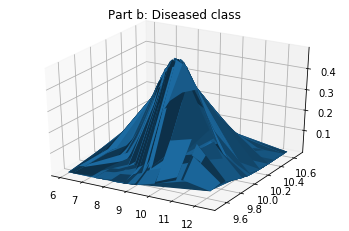

Plot of diseased class saved


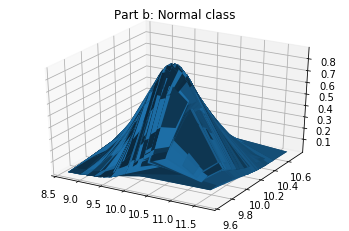

Plot of normal class saved
--------------------


Part c:
Normal class:
# accurate: 37
Accuracy: 84.0909090909091%

Diseased class:
# accurate: 28
Accuracy: 73.68421052631578%

Overall accuracy:
Accuracy: 79.26829268292683%
-------------


Part c:


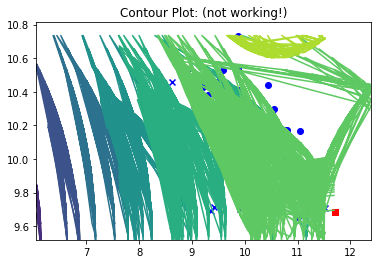

Contour plot not working!
Plotting original N and D points now


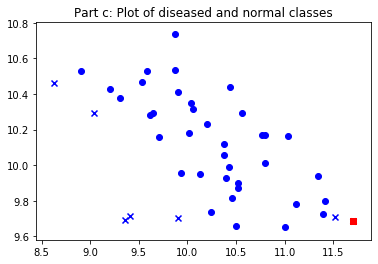

----------

Part d:


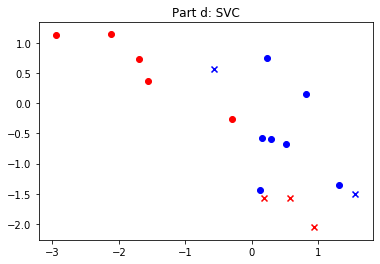

12 accurate out of 17
Accuracy: 70.58823529411765 %


In [530]:
def main():
    data = part_a_read_the_data()
    part_b_3D_surface_plot(data)
    data, answers = part_c_Bayesian_decision_function(data)
    part_c_plotting(data,answers)
    part_d_svmClassifier(data,answers)
    return
main()